# Variational Inference and Markov Chain Monte Carlo

Special credits to Doug for the code stub and several instances of text.

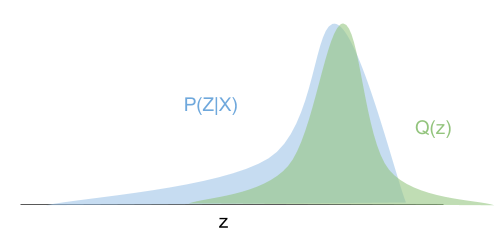

Image from Ashutosh Kushwaha's ["Variational Inference: Gaussian Mixture model"](https://ashkush.medium.com/variational-inference-gaussian-mixture-model-52595074247b) on Medium. 


Variational Inference (VI) methods frame approximation of intractable probability densities as a problem of optimization. VI tends to be faster than Markov Chain Monte Carlo (MCMC) methods, but sometimes at the cost of precision.

Today, we will explore how variational inference differs from MCMC when the posterior distribution's variables covary. 

First, we need to import our packages and create our training dataset.

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Number of datapoints
n = 11

# evenly spaced features
x_train = torch.linspace(0,1,n)

# design matrix
Phi = torch.vstack((torch.ones(n),x_train)).T

# "true" parameter values
W_true = torch.ones(2,1)

# Observational noise
sigma2_obs = 1e-2

# Compute the true y and corrupt with noise
y_train = Phi @ W_true + torch.randn(n,1)*np.sqrt(sigma2_obs)

Let's visualize our training data.

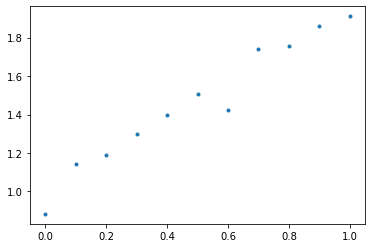

In [37]:
plt.plot(x_train,y_train,'.')

In our paper's overview of variational inference, we learned that we could optimize our approximation of the posterior by specifying a family of densities $\mathcal{Q}$ over the latent variables and finding some $q^* (\mathbf{z})$ that is closest in KL divergence to the posterior. 

We also found that the KL divergence could be manipulated to look like 


$$
\text{KL}(q(z) || p(z|x)) = \log p(x) - \int q(z) \log \frac{p(x,z)}{q(z)} dz,
$$

and that maximizing the second term, the Evidence Lower Bound, was all we needed to do to minimize this divergence.

Let's specify the prior distributions for our two model parameters, our slope and intercept. In this case, it would be a good choice to provide a vague prior, which will play a very minor role in influencing the posterior distribution.

A good choice for a diffuse prior would be mean $\mu = 0$ and a large variance (e.g. somewhere near 100). **Fill in the variance below.**

In [38]:
# Specify priors
mu_prior = torch.zeros(2,1)
sigma2_prior = torch.ones(2,1)
sigma2_prior.data[:]*=100.0

Now, let's make sure these look right.

In [39]:
mu_prior

tensor([[0.],
        [0.]])

In [ ]:
sigma2_prior

Next we'll initialize the parameters of our variational distribution.  

Recall from the paper that we will be using mean-field variational inference, where each latent variable is independent and therefore has its own density. The generic form of the mean-field variational family is

$$
q(\mathbf{z}) = \prod_{j=1}^m q_j (z_j).
$$


In our case, we will assume the mean-field approximation over both the slope and intercept with a normal variational posterior with learnable mean and standard deviation

$$
q(\mathbf{w}) = \mathcal{N}(w_0;\mu_0,\sigma_0) \mathcal{N}(w_1;\mu_1,\sigma_1).
$$

Note the parameterization in terms of standard deviation instead of variance.  This avoids having to explicitly constrain the variable to be positive.


In [40]:
mu_post = torch.rand(2,1,requires_grad=True)
sigma_post = torch.rand(2,1,requires_grad=True)

We will optimize the loss

$$
L = \frac{1}{m} \sum_{j=1}^m \log P(\mathbf{y}_{obs} | \mathbf{x}_{obs}, \mathbf{w}_j) + KL(q(\mathbf{w}) || p(\mathbf{w}) ),
$$

with $\mathbf{w}_j \sim q(\mathbf{w})$ and $p(\mathbf{w})$ the prior defined above.  Thus we need a log-likelihood and a function that computes the (analytical) KL distribution between two diagonal normals.  



In [41]:
def log_likelihood(y_pred,y_obs,sigma2_obs):
    return n/2*np.sqrt(2*np.pi*sigma2_obs) + 0.5/sigma2_obs*torch.sum((y_pred - y_obs)**2)

def kl_gaussian_diagonal(mu_post,mu_prior,sigma2_post,sigma2_prior):
    k = len(mu_post)
    log_det_ratio = torch.log(sigma2_prior).sum() - torch.log(sigma2_post).sum()
    sse = torch.sum((mu_post - mu_prior)**2/sigma2_prior)
    trace = (sigma2_post/sigma2_prior).sum()
    return 0.5*(log_det_ratio - k + sse + trace)

Now we can perform a training loop with simple stochastic gradient descent. **Fill in the number of iterations and samples.**

Text(0, 0.5, 'loss')

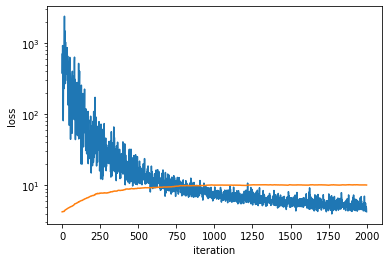

In [42]:
n_iterations = 2000

# Number of likelihood evaluations for MC-approximation to data loss
n_samples = 4

# step size (this is annoying to tune: better to use ADAM)
eta = 1e-5

data_losses = []
kl_losses = []

# training loop
for i in range(n_iterations):
  

    # Compute data loss
    L_data = 0
    for j in range(n_samples):
        # Sample parameters
        W = mu_post + torch.randn(2,1)*sigma_post
        
        # Compute forward model
        y_pred = Phi @ W
        
        # Update data loss
        L_data = L_data + log_likelihood(y_pred,y_train,sigma2_obs)/n_samples
    
    
    # Compute KL-loss (prior)
    L_kl = kl_gaussian_diagonal(mu_post,mu_prior,sigma_post**2,sigma2_prior)
    
    L = L_data + L_kl
    L.backward()
    
    data_losses.append(L_data.detach())
    kl_losses.append(L_kl.detach())
    
    # Gradient descent
    with torch.no_grad():
        mu_post -= eta*mu_post.grad
        sigma_post -= eta*sigma_post.grad
    mu_post.grad = None
    sigma_post.grad = None 
    
# Plot convergence 
plt.semilogy(data_losses)
plt.semilogy(kl_losses)
plt.xlabel('iteration')
plt.ylabel('loss')

Bayesian linear regression has an analytical solution for both posterior mean and (full) covariance matrix.  This is useful for comparison.  

In [43]:
# Posterior precision
Sigma_inv = 1./sigma2_obs*Phi.T @ Phi + torch.diag(1./sigma2_prior)

# Posterior covariance
Sigma = torch.linalg.inv(Sigma_inv)

# Posterior cholesky decomp (matrix square root)
L = torch.linalg.cholesky(Sigma)

# Posterior mean
mu_analytical = 1./sigma2_obs * Sigma @ Phi.T @ y_train

In [44]:
print(mu_post,sigma_post)
print(mu_analytical)

tensor([[1.0300],
        [0.8717]], requires_grad=True) tensor([[0.0306],
        [0.0515]], requires_grad=True)
tensor([[0.9814],
        [0.9668]])


We can visualize both the posterior predictive distribution (the set of lines that are consistent with the data) as well as the posterior distribution (the slope and intercept samples).

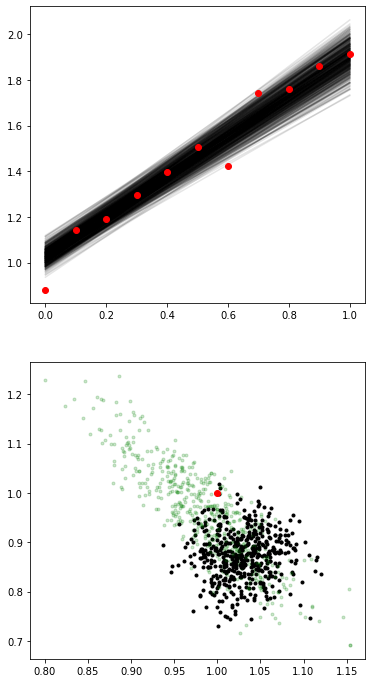

In [45]:
with torch.no_grad():
    # Number of posterior samples to draw
    n_plots = 500
    fig,axs = plt.subplots(nrows=2)
    w_0_samples = []
    w_1_samples = []
    for i in range(n_plots):
        # Random sample from variational posterior
        W = mu_post + torch.randn(2,1)*sigma_post
        y_pred = Phi @ W 
        # Plot predictive
        axs[0].plot(x_train,y_pred.detach(),'k-',alpha=0.1)
        # Plot parameters
        axs[1].plot(W[0],W[1],'k.')
        w_0_samples.append([W[0].item(),W[1].item()])
        # Bonus plot: samples drawn from the analytical posterior
        W_analytical = mu_analytical + L @ torch.randn(2,1)
        axs[1].plot(W_analytical[0],W_analytical[1],'g.',alpha=0.2)
        w_1_samples.append([W_analytical[0].item(),W_analytical[1].item()])
        
    # Plot data/true values
    axs[0].plot(x_train,y_train,'ro')
    axs[1].plot(W_true[0],W_true[1],'ro')
fig.set_size_inches(6,12)

In [46]:
w_0_samples = np.array(w_0_samples)
w_1_samples = np.array(w_1_samples)

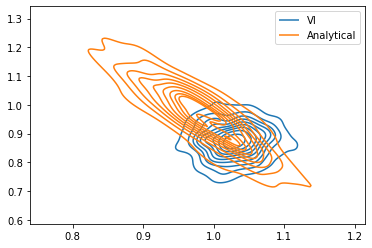

In [47]:
sns.kdeplot(x=w_0_samples[:,0], y=w_0_samples[:,1],label="VI")
sns.kdeplot(x=w_1_samples[:,0], y=w_1_samples[:,1],label="Analytical")
plt.legend()
plt.show()

Take a look at Figure 1 of the [Variational Inference paper](https://arxiv.org/pdf/1601.00670.pdf), page 9. What is at play here? In other words, why do these distributions look so different?

## Integrate MCMC functions

In [175]:
from utils import * #mcmc, mh

In [176]:
betas = mh(x_train, y_train, order=1, steps=10000)

In [177]:
coefs = mcmc(x_train, y_train, order=1)

In [178]:
mc_coeffs = torch.tensor(gen_coeffs(betas)).reshape((2,1))

with torch.no_grad():
    n_plots = 500
    mcc_samples = []
    
    for i in range(n_plots):
        W = mc_coeffs + torch.randn(2,1)
        mcc_samples.append([W[0].item(),W[1].item()])

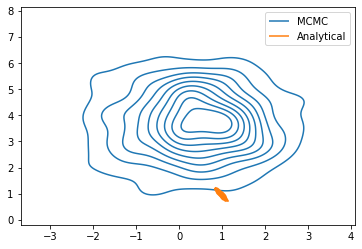

In [179]:
mcc_samples = np.array(mcc_samples)

sns.kdeplot(x=mcc_samples[:,0], y=mcc_samples[:,1],label="MCMC")
sns.kdeplot(x=w_1_samples[:,0], y=w_1_samples[:,1],label="Analytical")
plt.legend()
plt.show()